In [8]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [1]:
import os 
from random import shuffle 
from tqdm import tqdm 
from PIL import Image
import random
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 

In [2]:
train_empty = 'D:/Final_Project/traffic/Final Dataset/training/Empty'
train_high = 'D:/Final_Project/traffic/Final Dataset/training/High'
train_low = 'D:/Final_Project/traffic/Final Dataset/training/Low'
train_medium = 'D:/Final_Project/traffic/Final Dataset/training/Medium'
train_jam = 'D:/Final_Project/traffic/Final Dataset/training/Traffic Jam'

In [3]:
test_empty = 'D:/Final_Project/traffic/Final Dataset/validation/Empty'
test_high = 'D:/Final_Project/traffic/Final Dataset/validation/High'
test_low = 'D:/Final_Project/traffic/Final Dataset/validation/Low'
test_medium = 'D:/Final_Project/traffic/Final Dataset/validation/Medium'
test_jam = 'D:/Final_Project/traffic/Final Dataset/validation/Traffic Jam'

# Data Exploring

In [4]:
training_folder_path = 'D:/Final_Project/traffic/Final Dataset/training'
labels = [label for label in os.listdir(training_folder_path) if os.path.isdir(os.path.join(training_folder_path, label))]

# Sắp xếp nhãn
sorted_labels = sorted(labels)

# In tên nhãn
print("Sorted Labels:")
for label in sorted_labels:
    print(label)

Sorted Labels:
Empty
High
Low
Medium
Traffic Jam


In [5]:
training_subset="D:/Final_Project/traffic/Final Dataset/training"
test_subset="D:/Final_Project/traffic/Final Dataset/testing"
validation_subset="D:/Final_Project/traffic/Final Dataset/validation"
dataset_path = "D:/Final_Project/traffic/Final Dataset"


# hàm đếm ảnh theo nhãn trong từng folder
def count_images_per_label(folder_path):
    label_counts = {
        label: len(os.listdir(os.path.join(folder_path, label)))
        for label in os.listdir(folder_path)
        if os.path.isdir(os.path.join(folder_path, label))
    }

    return label_counts

if __name__ == "__main__":
    # Đếm số ảnh trong từng file
    training_label_counts = count_images_per_label(training_subset)
    test_label_counts = count_images_per_label(test_subset)
    validation_label_counts = count_images_per_label(validation_subset)
    sorted_training_label_counts = sorted(training_label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_test_label_counts = sorted(test_label_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_validation_label_counts = sorted(validation_label_counts.items(), key=lambda x: x[1], reverse=True)
print("Training Label Counts (sorted by count):")
for label, count in sorted_training_label_counts:
    print(f"{label}: {count}")
print("Test Label Counts (sorted by count):")

for label, count in sorted_test_label_counts:
    print(f"{label}: {count}")

print("Validation Label Counts (sorted by count):")
for label, count in sorted_validation_label_counts:
    print(f"{label}: {count}")

Training Label Counts (sorted by count):
Empty: 1186
Low: 936
Medium: 688
High: 378
Traffic Jam: 190
Test Label Counts (sorted by count):
Empty: 64
High: 64
Low: 64
Medium: 64
Traffic Jam: 64
Validation Label Counts (sorted by count):
Empty: 120
Low: 94
Medium: 70
High: 38
Traffic Jam: 18


In [6]:
# Tính tổng số ảnh trong từng file
def count_total_images(folder_path):
    total_images = 0
    for _, _, files in os.walk(folder_path):
        total_images += len(files)
    return total_images

total_images_count = count_total_images(dataset_path)
total_train_images_count = count_total_images(training_subset)
total_validation_images_count = count_total_images(validation_subset)
total_test_images_count = count_total_images(test_subset)


print(f"Total number of images in the main dataset: {total_images_count}")
print(f"Total number of images in the training dataset: {total_train_images_count}")
print(f"Total number of images in the test dataset: {total_test_images_count}")
print(f"Total number of images in the validation dataset: {total_validation_images_count}")


Total number of images in the main dataset: 4038
Total number of images in the training dataset: 3378
Total number of images in the test dataset: 320
Total number of images in the validation dataset: 340


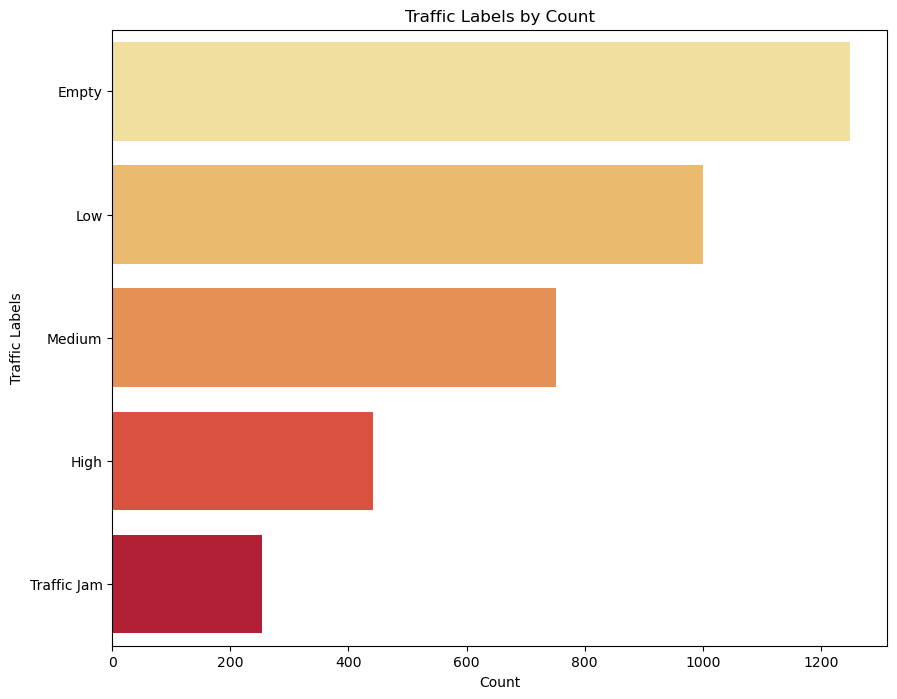

In [9]:
# Assuming you have `training_label_counts` and `test_label_counts` dictionaries defined

# Combine label counts from training and test datasets
combined_label_counts = {
    label: training_label_counts.get(label, 0) + test_label_counts.get(label, 0)
    for label in set(list(training_label_counts.keys()) + list(test_label_counts.keys()))
}

# Create a DataFrame to hold the combined traffic counts
df_traffic_counts = pd.DataFrame({"Traffic Labels": list(combined_label_counts.keys()), "Count": list(combined_label_counts.values())})

# Sort the DataFrame by the counts in descending order
df_traffic_counts = df_traffic_counts.sort_values(by="Count", ascending=False)

# Select the top 15 traffic labels by count
top_15_traffic = df_traffic_counts.head(15)

# Plot the horizontal bar chart using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x="Count", y="Traffic Labels", data=top_15_traffic, palette="YlOrRd")
plt.xlabel("Count")
plt.ylabel("Traffic Labels")
plt.title("Traffic Labels by Count")
plt.show()


## Coment 
- Như biểu đồ bên trên biểu diễn, Data đang là một imbalanced dataset 
- Khi data bị không cân bằng, điểu này dẫn đến hiệu suất của model không cao
--> Cách khắc phục : Sử dụng Data Augmentation, cách này giúp tạo nhiều data ảnh mới từ data sẵn có bằng các cách như là :
chỉnh độ tương phản, xoay, zoom,...
- Các ảnh mới được tạo ra không được lưu vào local mà tạo trực tiếp trong bộ nhớ RAM và được truyền cho model trong quá trình huấn luyện.

## Đầu tiên, sẽ thử train model khi chưa sử dụng phương pháp Augmentation

In [1]:
import os
import cv2
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
def getYourStatus(status, data_type, data_path, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']

    if data_type == 'Training':
        path = os.path.join(data_path, 'training')
    elif data_type == 'Test':
        path = os.path.join(data_path, 'testing')
    else:
        raise ValueError("Invalid data_type. Use 'Training', 'Test'")

    if not k_fold:
        for i, f in enumerate(status):
            p = os.path.join(path, f)
            j = 0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j += 1
            if print_n:
                print("There are", j, data_type, "images of", f)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            if v == 'Training':
                p = os.path.join(data_path, 'training')
            else:
                p = os.path.join(data_path, 'testing')

            for i, f in enumerate(status):
                path_status = os.path.join(p, f)
                j = 0
                for image_path in glob.glob(os.path.join(path_status, "*.jpg")):
                    image = cv2.imread(path_status, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j += 1

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

def getAllStatus(data_path):
    status = []
    for status_path in glob.glob(os.path.join(data_path, 'training', '*')):
        statu = os.path.basename(status_path)
        status.append(statu)
    return status

dim = 300


dataset_path = "D:/Final_Project/traffic/Final Dataset/"

In [2]:
from sklearn.preprocessing import StandardScaler
status = ['Empty', 'Low' , 'Medium', 'High', 'Traffic Jam']
x_train, y_train = getYourStatus(status, 'Training', dataset_path, print_n=True, k_fold=False)

# Example usage for testing data
x_test, y_test = getYourStatus(status, 'Test', dataset_path, print_n=True, k_fold=False)

# Scale Data Images
scaler = StandardScaler()

# Reshape images into 2D arrays before scaling
X_train = scaler.fit_transform([i.flatten() for i in x_train])
X_test = scaler.transform([i.flatten() for i in x_test])

There are 1186 Training images of Empty
There are 936 Training images of Low
There are 688 Training images of Medium
There are 378 Training images of High
There are 181 Training images of Traffic Jam
There are 64 Test images of Empty
There are 64 Test images of Low
There are 64 Test images of Medium
There are 64 Test images of High
There are 64 Test images of Traffic Jam


MemoryError: Unable to allocate 6.78 GiB for an array with shape (3369, 270000) and data type float64

# Data Augmentation

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2,
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = data_generator.flow_from_directory(
    directory="C:/Users/assas/Downloads/AIL/traffic/Final Dataset/training",
    target_size=(224, 224),
    class_mode='categorical',  # Change class_mode to 'categorical'
    subset='training',
    shuffle=True,
    seed=2,
    batch_size=32,
    color_mode='rgb'
)

valid_generator = data_generator.flow_from_directory(
    directory="C:/Users/assas/Downloads/AIL/traffic/Final Dataset/validation",
    target_size=(224, 224),
    class_mode='categorical',  # Change class_mode to 'categorical'
    subset='validation',
    shuffle=True,
    batch_size=32,
    color_mode='rgb'
)

classes = ['empty', 'low', 'medium', 'high', 'traffic jam']  # Update the list of classes


Found 2704 images belonging to 5 classes.
Found 66 images belonging to 5 classes.


Text(0.5, 1.0, 'On validation set')

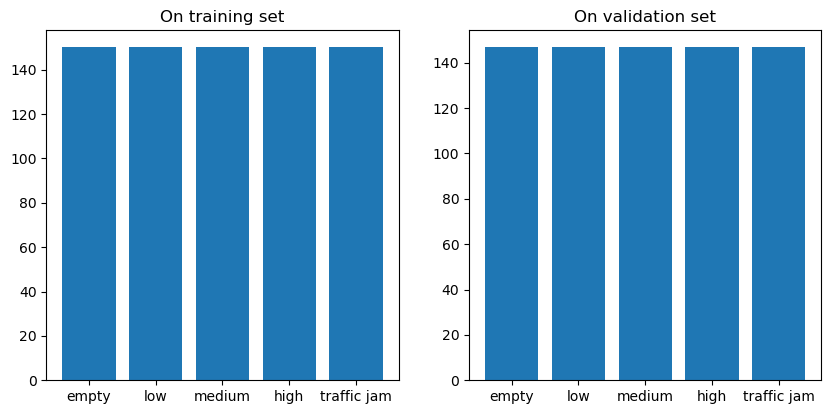

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.bar(classes, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('On training set')
plt.subplot(2,2,2)
plt.bar(classes, valid_generator.labels.sum(axis = 0)/valid_generator.n * 100)
plt.title('On validation set')

# Data Visualization 

## Empty 

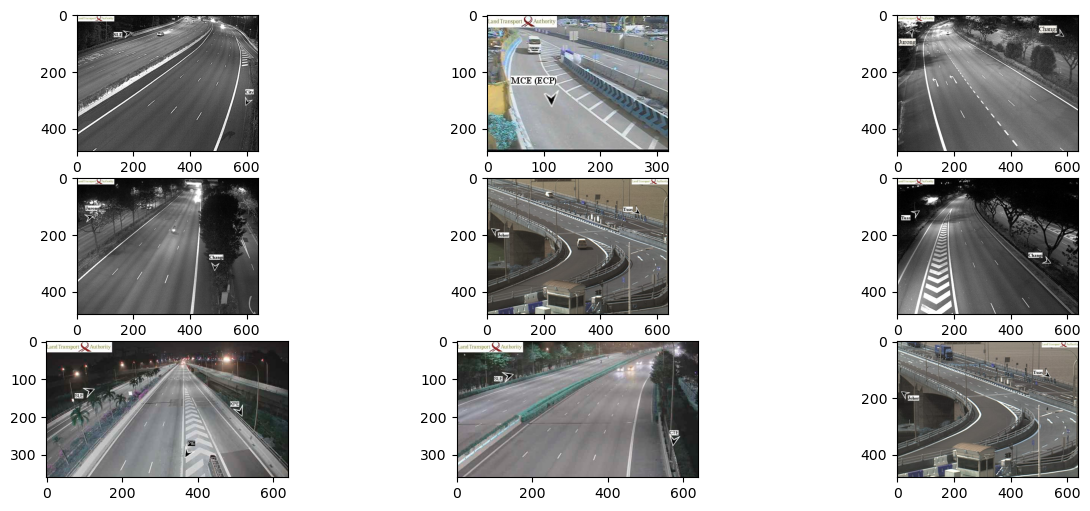

In [18]:
images = os.listdir(train_empty)
img_paths = [os.path.join(train_empty, i) for i in images]

img_paths[:5]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for a in ax.flatten():
    img = random.choice(img_paths)
    image = cv2.imread(img)
    a.imshow(image)

## High

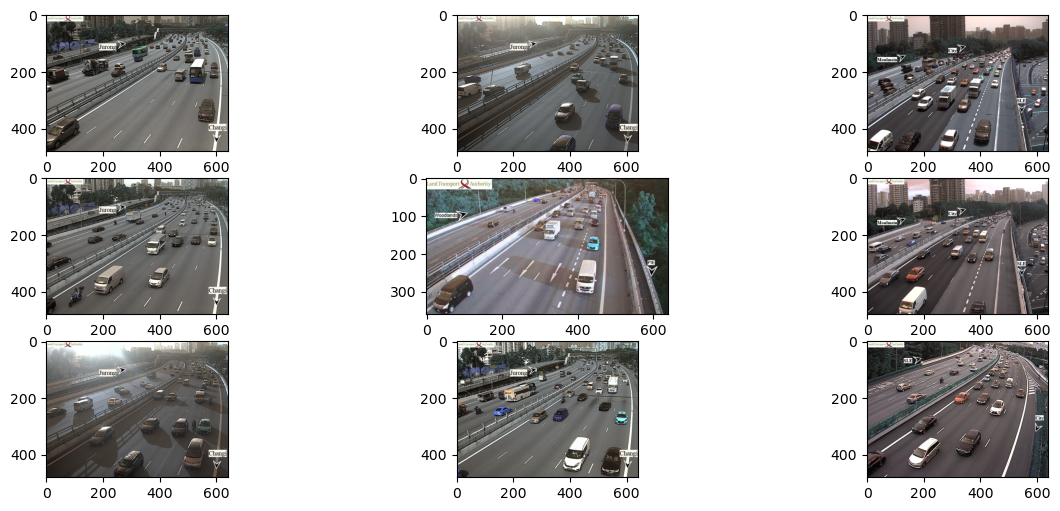

In [19]:
images = os.listdir(train_high)
img_paths = [os.path.join(train_high, i) for i in images]

img_paths[:5]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for a in ax.flatten():
    img = random.choice(img_paths)
    image = cv2.imread(img)
    a.imshow(image)

# Medium 

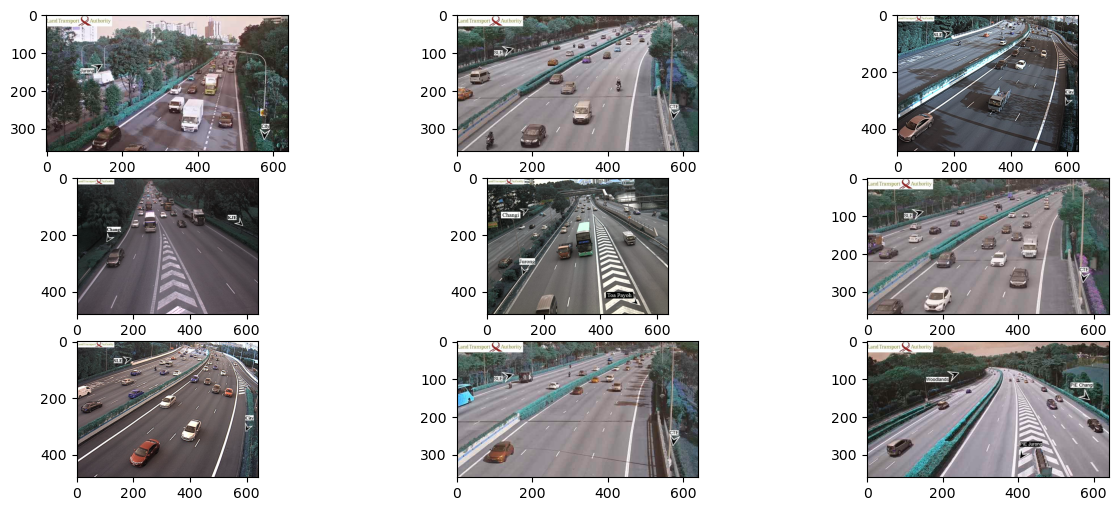

In [20]:
images = os.listdir(train_medium)
img_paths = [os.path.join(train_medium, i) for i in images]

img_paths[:5]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for a in ax.flatten():
    img = random.choice(img_paths)
    image = cv2.imread(img)
    a.imshow(image)

# Low

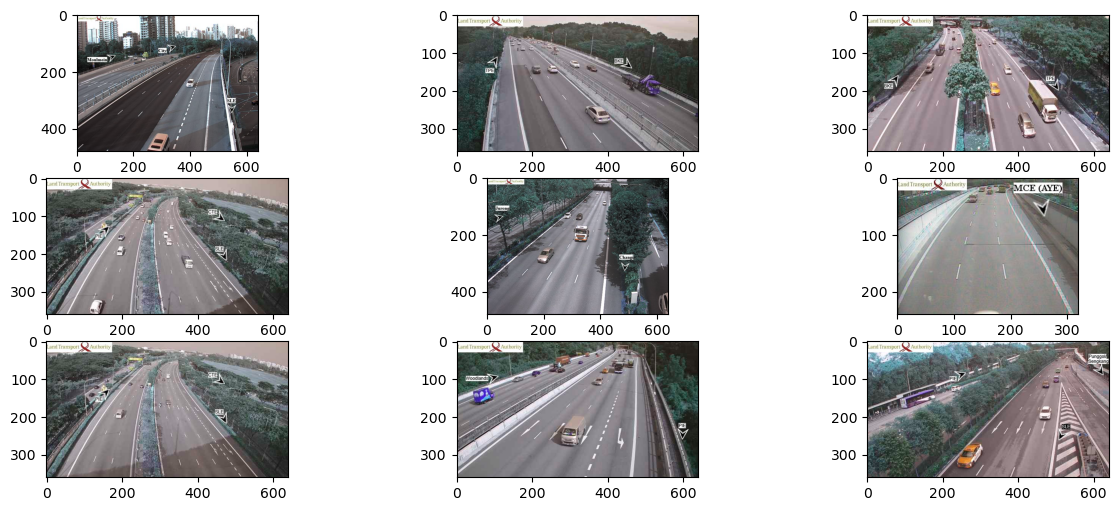

In [21]:
images = os.listdir(train_low)
img_paths = [os.path.join(train_low, i) for i in images]

img_paths[:5]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for a in ax.flatten():
    img = random.choice(img_paths)
    image = cv2.imread(img)
    a.imshow(image)

## Traffic Jam

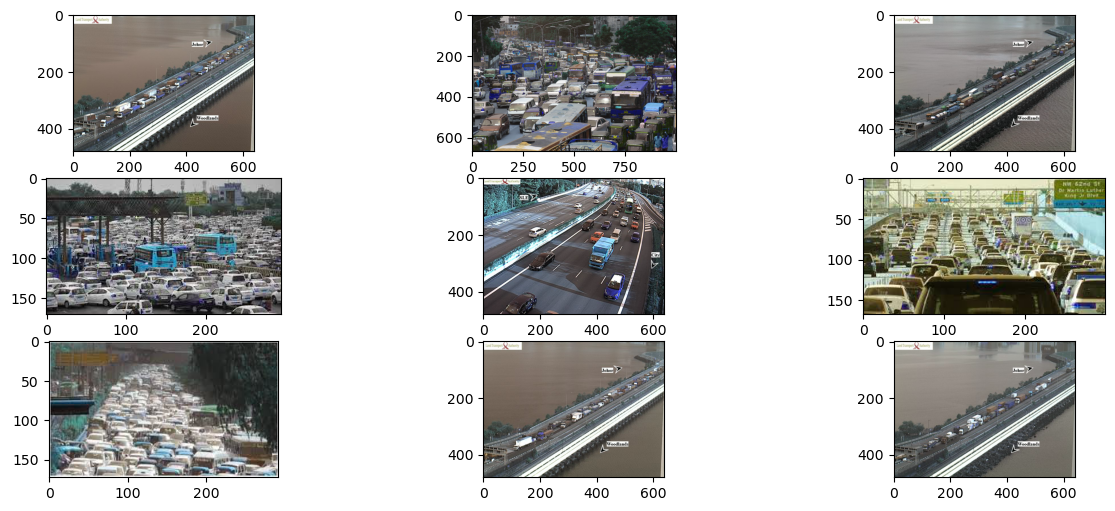

In [22]:
images = os.listdir(train_jam)
img_paths = [os.path.join(train_jam, i) for i in images]

img_paths[:5]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
for a in ax.flatten():
    img = random.choice(img_paths)
    image = cv2.imread(img)
    a.imshow(image)

# Pre-Processing Data

In [1]:
import os
import cv2
import glob
import numpy as np

def getYourFruits(fruits, data_type, data_path, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    
    if data_type == 'Training':
        path = os.path.join(data_path, 'training')
    elif data_type == 'Test':
        path = os.path.join(data_path, 'testing')
    elif data_type == 'Validation':
        path = os.path.join(data_path, 'validation')
    else:
        raise ValueError("Invalid data_type. Use 'Training', 'Test', or 'Validation'.")

    if not k_fold:
        for i, f in enumerate(fruits):
            p = os.path.join(path, f)
            j = 0
            for image_path in glob.glob(os.path.join(p, "*.jpg")):
                image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                image = cv2.resize(image, (dim, dim))
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                images.append(image)
                labels.append(i)
                j += 1
            if print_n:
                print("There are", j, data_type, "images of", f)
        
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            if v == 'Training':
                p = os.path.join(data_path, 'training')
            else:
                p = os.path.join(data_path, 'testing')
            
            for i, f in enumerate(fruits):
                path_fruit = os.path.join(p, f)
                j = 0
                for image_path in glob.glob(os.path.join(path_fruit, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j += 1
        
        images = np.array(images)
        labels = np.array(labels)
        return images, labels

def getAllFruits(data_path):
    fruits = []
    for fruit_path in glob.glob(os.path.join(data_path, 'training', '*')):
        fruit = os.path.basename(fruit_path)
        fruits.append(fruit)
    return fruits

dim = 100


dataset_path = "D:/Final_Project/traffic/Final Dataset/"


# Spliting Data

In [2]:
fruits = ['Empty', 'Low' , 'Medium', 'High', 'Traffic Jam']
x_train, y_train = getYourFruits(fruits, 'Training', dataset_path, print_n=True, k_fold=False)

# Example usage for testing data
x_test, y_test = getYourFruits(fruits, 'Test', dataset_path, print_n=True, k_fold=False)
x_val , y_val = getYourFruits(fruits, 'Validation', dataset_path, print_n=True, k_fold=False)

# Scale Data Images
scaler = StandardScaler()

# Reshape images into 2D arrays before scaling
X_train = scaler.fit_transform([i.flatten() for i in x_train])
X_test = scaler.transform([i.flatten() for i in x_test])

There are 1186 Training images of Empty
There are 936 Training images of Low
There are 688 Training images of Medium
There are 378 Training images of High
There are 181 Training images of Traffic Jam
There are 64 Test images of Empty
There are 64 Test images of Low
There are 64 Test images of Medium
There are 64 Test images of High
There are 64 Test images of Traffic Jam
There are 120 Validation images of Empty
There are 94 Validation images of Low
There are 70 Validation images of Medium
There are 37 Validation images of High
There are 17 Validation images of Traffic Jam


NameError: name 'StandardScaler' is not defined

# Model

### SVM

In [29]:
# SVM
model_svm = SVC(gamma='auto', kernel='linear')
model_svm.fit(X_train, y_train) 
y_pred_svm = model_svm.predict(X_test)
precision = metrics.accuracy_score(y_pred_svm, y_test) * 100
print("Accuracy with SVM: {0:.2f}%".format(precision))

Accuracy with SVM: 72.81%


In [30]:
percentage = model_svm.score(X_test, y_test)
print(f"Accuracy = {percentage*100} %")
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_svm, average='micro')

Accuracy = 72.8125 %


0.7281249999999999

### KNN

In [27]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
precision1 = metrics.accuracy_score(y_pred_knn, y_test) * 100
print("Accuracy with K-NN: {0:.2f}%".format(precision1))

Accuracy with K-NN: 43.12%


In [73]:
percentage = model_knn.score(X_test, y_test)
print(f"Accuracy = {percentage*100} %")
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_knn, average='micro')

Accuracy = 44.0625 %


0.440625

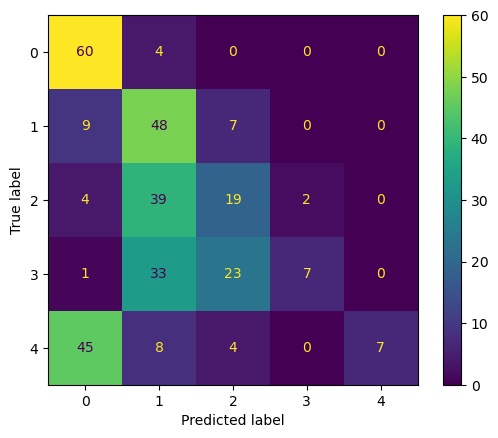

In [77]:
cm = confusion_matrix(y_test, y_pred_knn, labels = model_knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model_knn.classes_)
disp.plot()
plt.show()

### Decision Tree

In [26]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train,y_train)
y_pred_dt = model_dt.predict(X_test)
precision = metrics.accuracy_score(y_pred_dt, y_test) * 100
print("Accuracy with Decision Tree: {0:.2f}%".format(precision))

Accuracy with Decision Tree: 62.81%


### Random Forest

In [28]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=0) 
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_pred_rf, y_test) * 100
print("Accuracy with Random Forest: {0:.2f}%".format(accuracy))

Accuracy with Random Forest: 75.94%


In [74]:
percentage = model_rf.score(X_test, y_test)
print(f"Accuracy = {percentage*100} %")
f1_score(y_test, y_pred_rf, average='micro')

Accuracy = 70.3125 %


0.703125

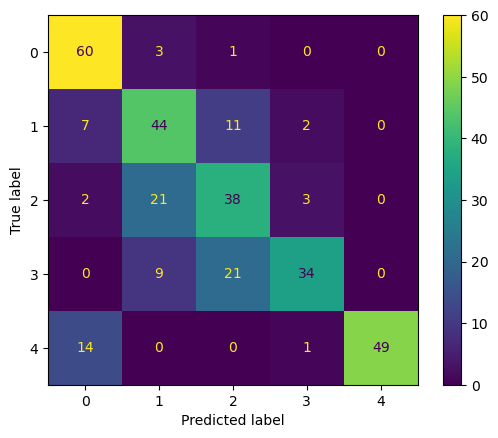

In [79]:
cm = confusion_matrix(y_test, y_pred_rf, labels = model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model_rf.classes_)
disp.plot()
plt.show()

### Logistic Regression 

In [37]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#Evaluation
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic: {0:.2f}%".format(precision))


Accuracy with Logistic: 71.88%


C:\Users\assas\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


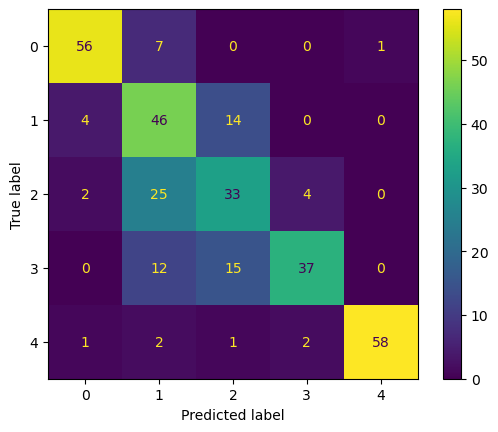

In [38]:
cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
disp.plot()
plt.show()